In [1]:
import numpy as np
import cv2 as cv
import skimage.io
import matplotlib.pyplot as plt
import os
import keras
from scipy import ndimage

Using TensorFlow backend.


In [6]:
np.__version__, cv.__version__, skimage.__version__, keras.__version__, ndimage.__version__

('1.18.1', '4.2.0', '0.16.2', '2.3.1', '2.0')

In [7]:
data_base_path = os.path.join(os.pardir, 'project')
data_folder = 'data/frame'

# Load image
data_path = os.path.join(data_base_path, data_folder)

frames = []

for i in range(42):
    frame = skimage.io.imread(os.path.join(data_path, 'frame'+str(i)+'.jpeg'))
    frames.append(frame)

In [8]:
data_path = os.path.join(data_base_path, 'data')

operator = skimage.io.imread(os.path.join(data_path, 'original_operators.png'))

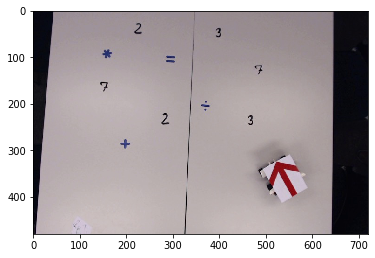

In [9]:
frames = np.asarray(frames)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(frames[0])
plt.show()

In [10]:
crop = frames[0][109:139, 469:499]

#binarization
gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
gray[gray<127] = 0
gray[gray>=127] = 1

In [11]:
crop = frames[0][220:248, 272:300]

#binarization
gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
gray[gray<127] = 0
gray[gray>=127] = 1


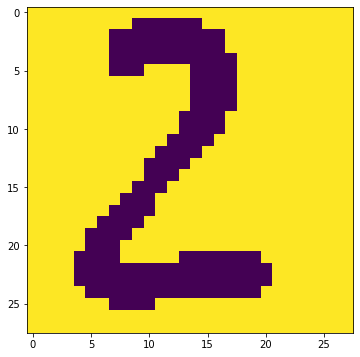

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(gray)
plt.show()

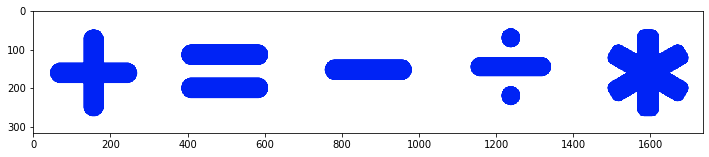

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(operator[:,:,:])
plt.show()

In [14]:
plus = operator[16:316, 0:300, :]
egal = operator[:, 350:650,:]
minus = operator[:, 700:1000,:]
div = operator[:, 1080:1380,:]
times = operator[:, 1450:1750,:]

operators = [plus, minus, div, times, egal]

In [15]:
egal.shape

(316, 300, 4)

In [16]:
img = egal

print('Original Dimensions : ',img.shape)
 
dim = (28, 28)
# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
img_div = resized[:,:,0]

Original Dimensions :  (316, 300, 4)
Resized Dimensions :  (28, 28, 4)


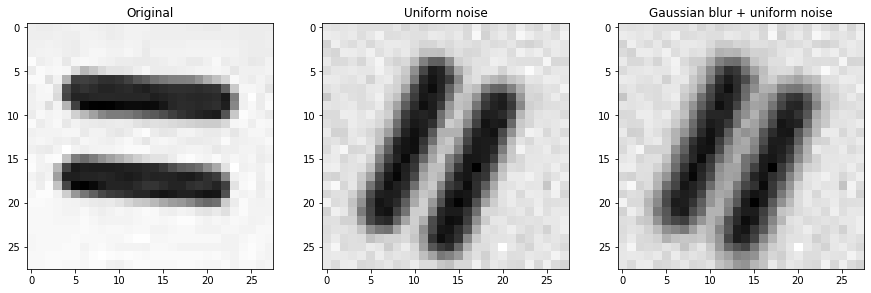

In [17]:
times_pos = (80, 145)
plus_pos = (273, 184) 
div_pos = (192, 357)
equal_pos = (92, 282)
size = 28

pos = equal_pos
img = egal


dim = (size, size)
# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
 
img = resized[:,:,0]


img = ndimage.rotate(img, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
img = cv.warpAffine(img, T, img.shape, borderValue=255)

noise = np.random.normal(0,10,(28,28))
g_blur = cv.GaussianBlur(img, (3, 3), 10, 10)
g_blur = g_blur + noise
unif_blur = img + noise

img = frames[0][pos[0]:pos[0]+size, pos[1]:pos[1]+size]
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)


fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(unif_blur, cmap='gray')
ax[1].set_title('Uniform noise')
ax[2].imshow(g_blur, cmap='gray')
ax[2].set_title('Gaussian blur + uniform noise')
plt.show()

In [18]:
dataset = []

for img in [plus, minus, div, times, egal]:
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    resized = cv.resize(gray, (size, size), interpolation = cv.INTER_AREA)

    for i in range(10_000):
        size = 28
        rotated = ndimage.rotate(resized, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
        T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
        translated = cv.warpAffine(rotated, T, rotated.shape, borderValue=255)

        noise = np.random.normal(0,15,(28,28))
        g_blur = cv.GaussianBlur(translated, (3, 3), 10, 10)
        out = g_blur + noise
        
        dataset.append(out)
        
dataset = np.array(dataset)
print(dataset.shape)

(50000, 28, 28)


In [19]:
with open('data/dataset.npy', 'wb') as f:
    np.save(f, dataset)

In [20]:
test_dataset = []

for img in [plus, minus, div, times, egal]:
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    resized = cv.resize(gray, (size, size), interpolation = cv.INTER_AREA)

    for i in range(1000):
        size = 28
        rotated = ndimage.rotate(resized, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
        T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
        translated = cv.warpAffine(rotated, T, rotated.shape, borderValue=255)

        noise = np.random.normal(0,15,(28,28))
        g_blur = cv.GaussianBlur(translated, (3, 3), 10, 10)
        out = g_blur + noise
        
        test_dataset.append(out)
        
test_dataset = np.array(test_dataset)
print(test_dataset.shape)

(5000, 28, 28)


In [21]:
with open('data/test_dataset.npy', 'wb') as f:
    np.save(f, test_dataset)

In [36]:
##OPERATOR TRAIN DATASET

"""
Encoding: plus = 0, minus = 1, div = 2, times = 3, egal = 4
"""

plus = np.expand_dims(dataset[:6000,:,:], axis=3)
minus = np.expand_dims(dataset[10000:16000,:,:], axis=3)
div = np.expand_dims(dataset[20000:26000,:,:], axis=3)
times = np.expand_dims(dataset[30000:36000,:,:], axis=3)
egal = np.expand_dims(dataset[40000:46000,:,:], axis=3)

yplus = np.ones(6000)*0
yminus = np.ones(6000)*1
ydiv = np.ones(6000)*2
ytimes = np.ones(6000)*3
yegal = np.ones(6000)*4

x_op_train = np.concatenate((plus, minus, div, times, egal), axis=0)
y_op_train = np.concatenate((yplus, yminus, ydiv, ytimes, yegal), axis=0)



## OPERATOR TEST DATASET


plus = np.expand_dims(test_dataset[:1000,:,:], axis=3)
minus = np.expand_dims(test_dataset[1000:2000,:,:], axis=3)
div = np.expand_dims(test_dataset[2000:3000,:,:], axis=3)
times = np.expand_dims(test_dataset[3000:4000,:,:], axis=3)
egal = np.expand_dims(test_dataset[4000:5000,:,:], axis=3)

yplus = np.ones(1000)*0
yminus = np.ones(1000)*1
ydiv = np.ones(1000)*2
ytimes = np.ones(1000)*3
yegal = np.ones(1000)*4


x_op_test = np.concatenate((plus, minus, div, times, egal), axis=0)
y_op_test = np.concatenate((yplus, yminus, ydiv, ytimes, yegal), axis=0)


print('Test set dimension:', x_op_test.shape, y_op_test.shape)
print('Train set dimension:', x_op_train.shape, y_op_train.shape)


#preprocessing
x_op_train = x_op_train.astype('float32')
x_op_test = x_op_test.astype('float32')
x_op_train /= 255
x_op_test /= 255


# convert class vectors to binary class matrices

num_classes = 5
y_op_train = keras.utils.to_categorical(y_op_train, num_classes)
y_op_test = keras.utils.to_categorical(y_op_test, num_classes)

Test set dimension: (5000, 28, 28, 1) (5000,)
Train set dimension: (30000, 28, 28, 1) (30000,)


In [39]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K



batch_size = 128
num_classes = 15
epochs = 3
img_rows, img_cols = 28, 28
num_classes = 5

operator_classifier = Sequential()
operator_classifier.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
operator_classifier.add(Conv2D(64, (3, 3), activation='relu'))
operator_classifier.add(MaxPooling2D(pool_size=(2, 2)))
operator_classifier.add(Dropout(0.25))
operator_classifier.add(Flatten())
operator_classifier.add(Dense(128, activation='relu'))
operator_classifier.add(Dropout(0.5))
operator_classifier.add(Dense(num_classes, activation='softmax'))

operator_classifier.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

operator_classifier.fit(x_op_train, y_op_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_op_test, y_op_test))
score = operator_classifier.evaluate(x_op_test, y_op_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 30000 samples, validate on 5000 samples
Epoch 1/3
30000/30000 [==============================] - 26s 853us/step - loss: 0.4952 - accuracy: 0.8017 - val_loss: 0.0242 - val_accuracy: 0.9924
Epoch 2/3
30000/30000 [==============================] - 26s 873us/step - loss: 0.0338 - accuracy: 0.9899 - val_loss: 0.0046 - val_accuracy: 0.9986
Epoch 3/3
30000/30000 [==============================] - 27s 902us/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.0011 - val_accuracy: 0.9998
Test loss: 0.0011225040893398613
Test accuracy: 0.9998000264167786


In [80]:
def remove(digit, x, y):
    idx = (y != digit).nonzero()
    return x[idx], y[idx]

In [79]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 9
epochs = 3


img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#remove 9 to avoid 9 vs 6 problem
x_train, y_train = remove(9, x_train, y_train)
x_test, y_test = remove(9, x_test, y_test)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (54051, 28, 28, 1)
54051 train samples
8991 test samples


In [81]:
from keras.preprocessing.image import ImageDataGenerator
# applying transformation to image, roation and flip
train_gen = ImageDataGenerator(rotation_range=90, 
                               #width_shift_range=0.08, 
                               #shear_range=0.3, 
                               #height_shift_range=0.08,
                               horizontal_flip=True,
                               vertical_flip=True,
                             )
test_gen = ImageDataGenerator()

training_set= train_gen.flow(x_train, y_train, batch_size=128)
test_set= train_gen.flow(x_test, y_test, batch_size=128)

In [82]:
batch_size = 10
epochs = 2
num_classes = 9

digit_classifier = Sequential()
digit_classifier.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
digit_classifier.add(Conv2D(64, (3, 3), activation='relu'))
digit_classifier.add(MaxPooling2D(pool_size=(2, 2)))
digit_classifier.add(Dropout(0.25))
digit_classifier.add(Flatten())
digit_classifier.add(Dense(128, activation='relu'))
digit_classifier.add(Dropout(0.5))
digit_classifier.add(Dense(num_classes, activation='softmax'))

digit_classifier.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


In [84]:
digit_classifier.fit_generator(training_set, 
                         steps_per_epoch=60000//64, 
                         validation_data= test_set, 
                         validation_steps=10000//64, 
                         epochs=5)

Epoch 1/5
937/937 [==============================] - 112s 119ms/step - loss: 0.8654 - accuracy: 0.7076 - val_loss: 0.3885 - val_accuracy: 0.8920
Epoch 2/5
937/937 [==============================] - 121s 129ms/step - loss: 0.4681 - accuracy: 0.8511 - val_loss: 0.1965 - val_accuracy: 0.9225
Epoch 3/5
937/937 [==============================] - 125s 133ms/step - loss: 0.3891 - accuracy: 0.8782 - val_loss: 0.2665 - val_accuracy: 0.9274
Epoch 4/5
937/937 [==============================] - 127s 135ms/step - loss: 0.3461 - accuracy: 0.8914 - val_loss: 0.1904 - val_accuracy: 0.9384
Epoch 5/5
937/937 [==============================] - 128s 137ms/step - loss: 0.3211 - accuracy: 0.9003 - val_loss: 0.1656 - val_accuracy: 0.9459


In [89]:
digit_classifier.save("digit_classifier.h5")
operator_classifier.save("operator_classifier.h5")
print("Saved models to disk")

Saved models to disk


In [ ]:
from keras.models import load_model
 
# TO LOAD A MODEL
model = load_model('model.h5')

In [87]:
#example from test set

random = np.random.randint(low = 0, high = 6000, size = 10) 

for i in range(10):
    example = np.reshape(x_test[random[i]], (1,28,28,1))
    prediction = digit_classifier.predict(example) #new prediction on the preprocessed extracted image
    print('model prediction:', prediction.argmax(), 'right prediction:', y_test[random[i]].argmax())

model prediction: 1 right prediction: 1
model prediction: 5 right prediction: 5
model prediction: 6 right prediction: 6
model prediction: 8 right prediction: 8
model prediction: 4 right prediction: 4
model prediction: 2 right prediction: 2
model prediction: 7 right prediction: 7
model prediction: 3 right prediction: 3
model prediction: 5 right prediction: 2
model prediction: 7 right prediction: 7


In [237]:
seven = frames[0][111:139, 471:499]
two = frames[0][220:248, 272:300]

#binarization
seven = cv.cvtColor(seven, cv.COLOR_BGR2GRAY)
two = cv.cvtColor(two, cv.COLOR_BGR2GRAY)


#preprocessing
seven = seven.astype('float32')
two = two.astype('float32')
seven /= 255
two /= 255

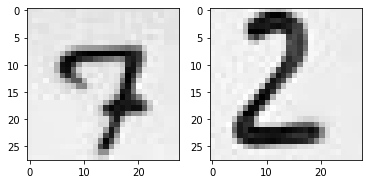

In [238]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(seven, cmap='gray')
ax[1].imshow(two, cmap='gray')
plt.show()

In [239]:
seven = np.reshape(seven, (1, 28, 28, 1))

prediction = digit_classifier.predict(seven) #new prediction on the preprocessed extracted image
prediction.argmax()

14

In [241]:
two = np.reshape(two, (1, 28, 28, 1))

prediction = digit_classifier.predict(two) #new prediction on the preprocessed extracted image
prediction.argmax()

2